In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch import nn

: 

In [95]:
class KalmanFilter(object):
    def __init__(self, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.size(1)
        self.m = H.size(1)

        self.F = F.float()
        self.H = H.float()
        self.B = torch.zeros(1) if B is None else B
        self.Q = torch.eye(self.n).float() if Q is None else Q
        self.R = torch.eye(self.n).float() if R is None else R
        self.P = torch.eye(self.n).float() if P is None else P
        self.x = torch.zeros((self.n)).float() if x0 is None else x0
 
    def predict(self, u = torch.zeros(1)):
        self.x = self.F @ self.x + self.B @ u
        self.P = self.F @ self.P @ self.F.T + self.Q
        return self.x

    def update(self, z):
        y = z - self.H @ self.x
        S = self.R + self.H @ self.P.float() @ self.H.T
        K = self.P @ self.H.T @ torch.inverse(S)
        self.x = self.x + K.float() @ y.float()
        I = torch.eye(self.n)
        self.P = (I - K @ self.H) @ self.P @ (I - K @ self.H).T + K @ self.R @ K.T

In [96]:
class PolyFilter(object):
    def __init__(self, S = None):

        if(S is None):
            raise ValueError("Set proper shift operator")
        
        self.S = S
        self.N = S.shape[0]

    def compute(self, c):
        self.H = np.zeros((self.N,self.N))
        for i in range(len(c)):
            self.H += c[i]*np.linalg.matrix_power(self.S, i)
        return self.H


In [97]:
# def example():
# 	dt = 1.0/60
# 	F = np.array([[1, dt, 0], [0, 1, dt], [0, 0, 1]])
# 	H = np.array([1, 0, 0]).reshape(1, 3)
# 	Q = np.array([[0.05, 0.05, 0.0], [0.05, 0.05, 0.0], [0.0, 0.0, 0.0]])
# 	R = np.array([0.5]).reshape(1, 1)

# 	x = np.linspace(-10, 10, 100)
# 	measurements = - (x**2 + 2*x - 2)  + np.random.normal(0, 2, 100)

# 	kf = KalmanFilter(F = F, H = H, Q = Q, R = R)
# 	predictions = []

# 	for z in measurements:
# 		predictions.append(np.dot(H,  kf.predict())[0])
# 		kf.update(z)

# 	import matplotlib.pyplot as plt
# 	plt.plot(range(len(measurements)), measurements, label = 'Measurements')
# 	plt.plot(range(len(predictions)), np.array(predictions), label = 'Kalman Filter Prediction')
# 	plt.legend()
# 	plt.show()

# if __name__ == '__main__':
#     example()

In [98]:
edge_set =  [[1,2], [2,5], [2,3], [3,4], [4,5], [5,6], [6,7], [7,8], [7,9], [8,10], [9,11], [11,12], [12,13], [13,14], [13,16], [14,15],
            [14,20], [15,17], [15,24], [16,17], [16,19], [17,18], [18,32], [20,21], [20,22], [21,22], [22,33], [23,25], [24,23], [25,26],
            [25,31], [27,29], [28,35], [28,36], [29,28], [29,35], [31,27], [32,19], [33,34], [35,30]]
df_e = pd.read_csv('water_data/Flow.csv',header=None)
df_n = pd.read_csv('water_data/Pressure.csv',header=None)
df = pd.concat([df_e, df_n],ignore_index=True)

In [99]:
G = nx.Graph(edge_set)
L0 = nx.laplacian_matrix(G).todense()
B = nx.incidence_matrix(G,oriented=True).todense()
L1 = B.T@B

In [100]:
A_e = np.concatenate((L1,B.T), axis=1)
A_n = np.concatenate((B,L0), axis=1)
A = np.concatenate((A_e,A_n))

In [101]:
c_ee = [1   ,  .5   , .2]
c_en = [.2  ,  .25  , .39]
c_ne = [.4  ,  .15  , .82]
c_nn = [.9  ,  .95  , .12]
norm_factor = np.linalg.norm(B,ord=2)

h_n = PolyFilter(L0)
h_e = PolyFilter(L1)

h_ee = h_e.compute(c_ee)
h_en = (B.T/norm_factor) @ h_n.compute(c_en)
h_ne = (B/norm_factor) @ h_e.compute(c_ne)
h_nn = h_n.compute(c_nn)

H_e = np.concatenate((h_ee,h_en), axis=1)
H_n = np.concatenate((h_ne,h_nn), axis=1)
H = np.concatenate((H_e,H_n))

#scaling for normalization of incidence matrix spectral norm

In [102]:
sigma_q = .5
sigma_r = .5
N = df.shape[0] 

Y = df.to_numpy()
predictions = []

kf = KalmanFilter(F = torch.tensor(A), H = torch.tensor(H), Q = sigma_q*torch.eye(N), R = sigma_r*torch.eye(N))

for z in Y.T:
    predictions.append(torch.tensor(H).float() @ kf.predict())
    kf.update(torch.tensor(z))


In [103]:
X_hat = torch.stack(predictions).T
X_hat.size()

torch.Size([76, 112])

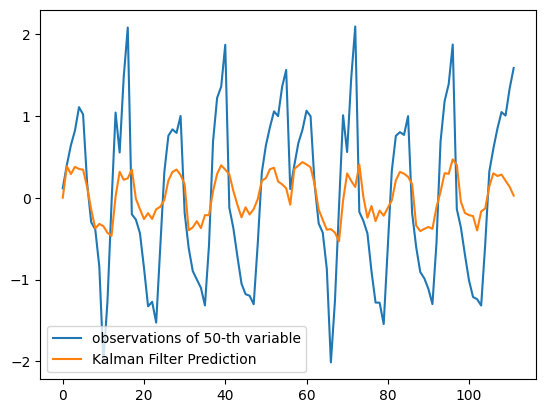

In [104]:
T = Y.shape[1]
X_hat = torch.stack(predictions).T
j = 50
plt.plot(range(T), Y[j,:], label = f'observations of {j}-th variable')
plt.plot(range(T), X_hat[j,:], label = 'Kalman Filter Prediction')
plt.legend()
plt.show()

In [105]:
def gf_conv(S, c):
        N = S.shape[0]
        H = torch.zeros((N,N))
        S = torch.tensor(S)
        for i in range(len(c)):
            H += c[i]*torch.linalg.matrix_power(S, i)
        return H

class GFSSM(nn.Module):
    def __init__(self, K, B):
        super().__init__()
        self.c_ee = nn.Parameter(torch.randn(K))
        self.c_en = nn.Parameter(torch.randn(K))
        self.c_ne = nn.Parameter(torch.randn(K))
        self.c_nn = nn.Parameter(torch.randn(K))
        
        self.B = B
        self.K = K
        self.L0 = B @ B.T
        self.L1 = B.T @ B
        self.n = B.shape[0]
        self.m = B.shape[1]
        # self.H = torch.zeros((self.n+self.m,self.n+self.m))
    
    def gf_generator(self):
        h_ee = gf_conv(self.L1, self.c_ee)
        h_en = torch.tensor(self.B.T).float() @ gf_conv(self.L0, self.c_en)
        h_ne = torch.tensor(self.B).float() @ gf_conv(self.L1, self.c_ne)
        h_nn = gf_conv(self.L0, self.c_nn)

        H_e = torch.cat((h_ee,h_en), 1)
        H_n = torch.cat((h_ne,h_nn), 1)
        H = torch.cat((H_e,H_n), 0)
        return H
    
    def diffusion_generator(self):
        A_e = np.concatenate((self.L1,self.B.T), 1)
        A_n = np.concatenate((self.B,self.L0), 1)
        A = np.concatenate((A_e,A_n), 0)
        return torch.tensor(A)
    

    def forward(self, y):
        T = y.size(1)
        y_hat = []

        A = self.diffusion_generator()
        H = self.gf_generator()

        kf = KalmanFilter(F = A, H = H, Q = np.eye(N), R = np.eye(N))

        for t in range(T):
            y_hat.append(H @ kf.predict())
            kf.update(y[:,t])
        
        return y_hat
    

In [106]:
y = torch.from_numpy(Y)
y_label = torch.roll(y,-1,dims=1)

y_train = y[:,:80]
y_train_label = y_label[:,:80]
y_val = y[:,80:]
y_val_label = y_label[:,80:]

In [107]:
from torch.utils.data import DataLoader
training_loader = DataLoader(list(zip(y_train.T,y_train_label.T)), shuffle=False)
validation_loader = DataLoader(list(zip(y_val.T,y_val_label.T)), shuffle=False)

In [108]:
next(iter(training_loader))[0].size()

torch.Size([1, 76])

In [109]:
model = GFSSM(3, B)
lr = 1e-3
epochs = 5
batch_size = 4
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [110]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [111]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [112]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


TypeError: Concatenation operation is not implemented for NumPy arrays, use np.concatenate() instead. Please do not rely on this error; it may not be given on all Python implementations.